# Advanced Explorative Data Analysis
TODO: Text!

In [1]:
# Import necessary libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [2]:
# Import data and remove NaNs (races which weren't finished)
data = pd.read_csv("data/cleaned_data/races_cleaned.csv")
data[["race_created", "race_driven"]] = \
    data[["race_created", "race_driven"]].astype("datetime64")
data.dropna(inplace=True)


In [2]:
# Parameter
title_fontsize = 25
axis_fontsize = 20
legend_size = 20
tick_label_fontsize = 15


## 1 Fuel consumption
We have finally cleaned the data set, so how does it look like?

### 1.1 Distribution
how is it distributed?

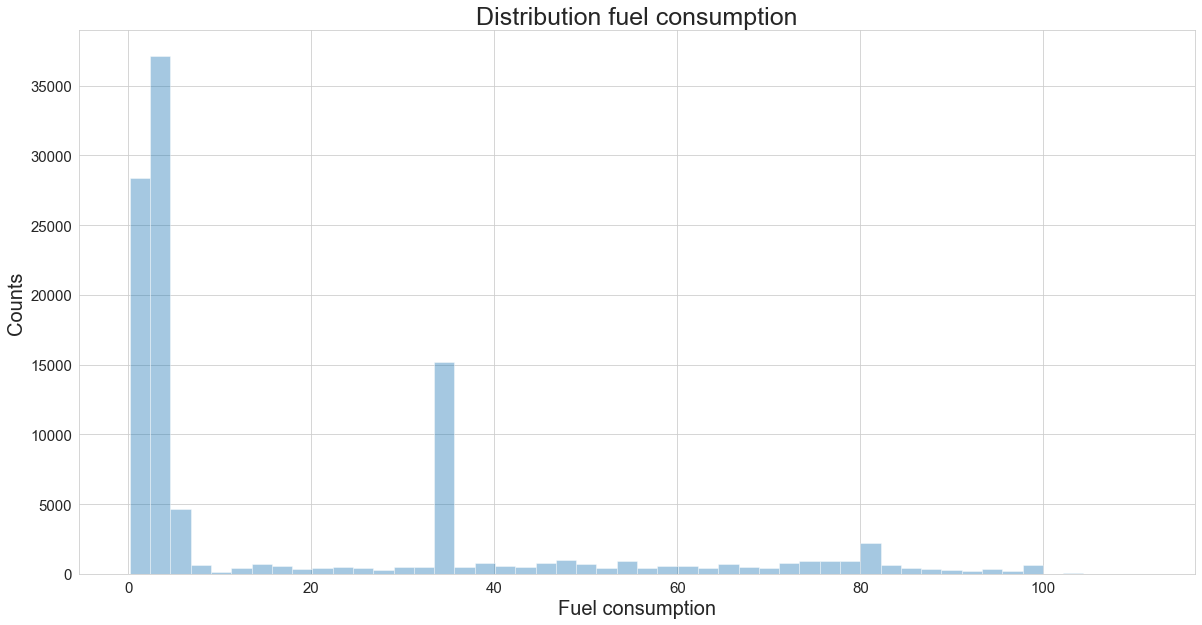

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.distplot(data["fuel_consumption"], kde=False)
plt.title("Distribution fuel consumption", fontsize=title_fontsize)
plt.xlabel("Fuel consumption", fontsize=axis_fontsize)
plt.ylabel("Counts", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=15)

plt.show()

TODO: text: meist wenig fuel zweiter peak bei etwa 35

### 1.2 What effects fuel consumption?
Can we find some connections between different variables. In particular, for fuel consumption and money?

Obviously no connection to track or weather. Thus, it remains unclear what affects fuel consumption. given that only one value it might be a condition on the race itself? otherwise you would also expect two values - opp/chal. However, without further information only speculation

## 2 Money
Are the high values correlated to something?

In [ ]:
df_money = data.loc[data.money>=200000]  # consider only high values of money

fig, ax = plt.subplots(2, 1, figsize=(20, 10)) # TODO: plot schön!

sns.scatterplot(x="money", y="fuel_consumption", data=df_money, ax=ax[0]) # no number of labs?
ax[0].set_title("High money vs. fuel consumption", fontsize=title_fontsize)
ax[0].set_xlabel("Money", fontsize=axis_fontsize)
ax[0].set_ylabel("Fuel consumption", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=15)


sns.scatterplot(x="money", y="weather", data=df_money, ax=ax[1]) # no conditions on track
ax[1].set_title("High money vs. weather", fontsize=title_fontsize)
ax[1].set_xlabel("Money", fontsize=axis_fontsize)
ax[1].set_ylabel("Weather", fontsize=axis_fontsize)
ax[1].tick_params(axis="both", which="major", labelsize=15)

fig.tight_layout()
plt.show()

most likely choosable by players? though still unclear why so many glatte low values..

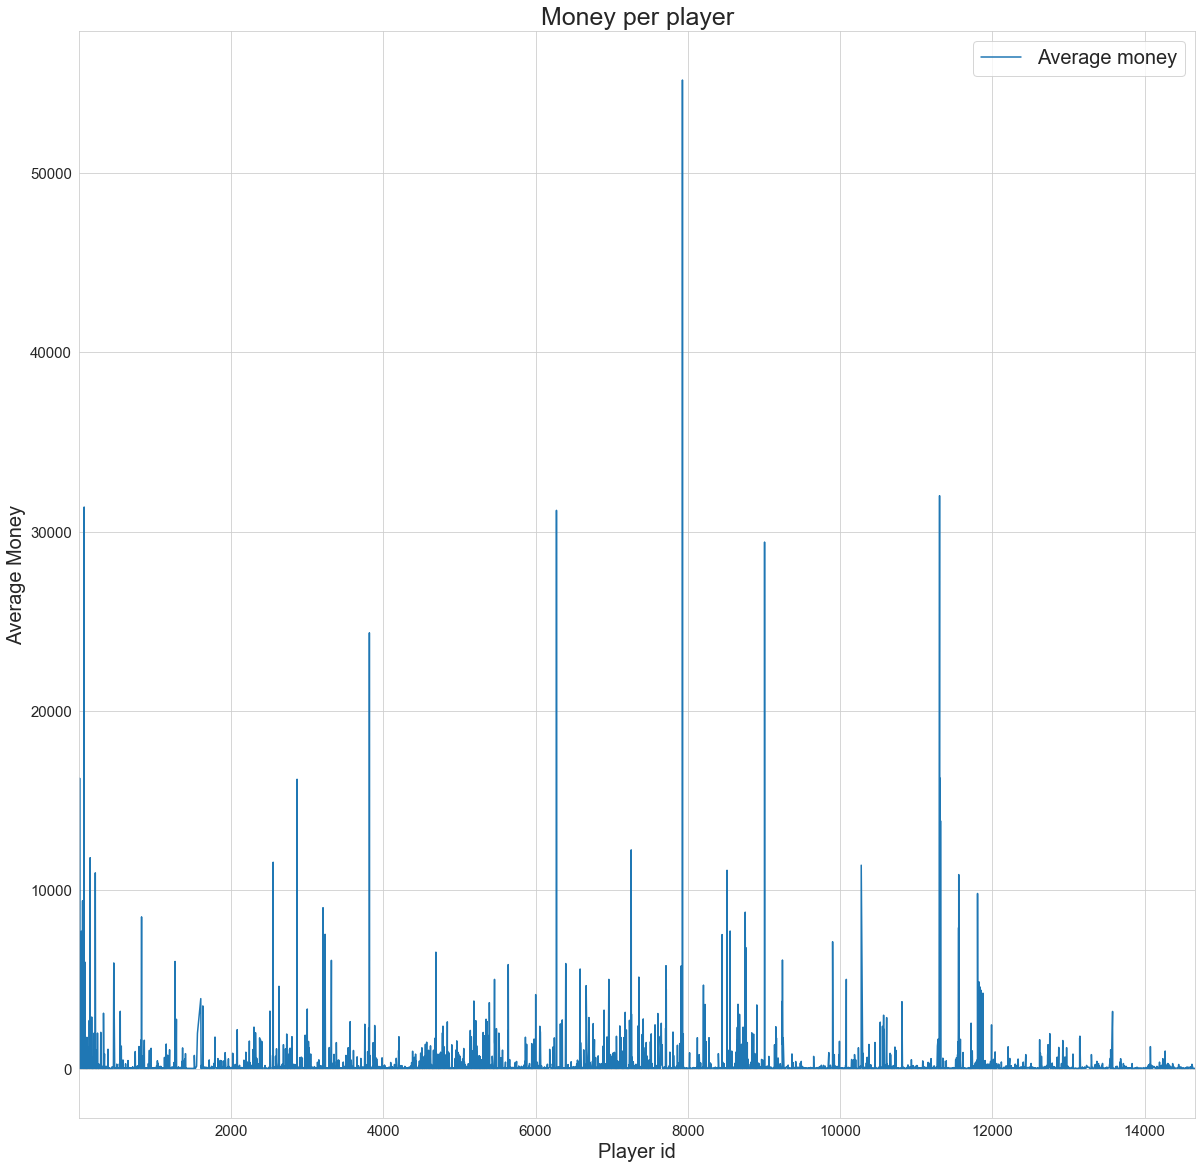

In [6]:
df_player = pd.DataFrame(data.groupby("challenger").mean()).reset_index()
df_player.rename(columns={"challenger": "player"}, inplace=True)
df_player = df_player[["player", "money"]]
df_player
df_opponent = pd.DataFrame(data.groupby("opponent").mean()).reset_index()
df_opponent.rename(columns={"opponent": "player"}, inplace=True)
df_opponent = df_opponent[["player", "money"]]
df_opponent
df_player = df_player.append(df_opponent).groupby("player").mean()
df_player = df_player.iloc[1:]  # remove first because that is when no race happened


fig, ax = plt.subplots(figsize=(20, 20))

df_player.plot(ax=ax)
plt.title("Money per player", fontsize=title_fontsize)
plt.xlabel("Player id", fontsize=axis_fontsize)
plt.ylabel("Average Money", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(["Average money"], prop={"size": legend_size})

# TODO: plot anpassen! Title etc
plt.show()

Obvioulsy a few player quite rich. Most likely playerd against rich player?

In [ ]:

# %%
# Extract hours per player
df_challenger = pd.DataFrame(data.groupby("challenger").apply(lambda x: x.race_driven.dt.strftime("%H"))).reset_index(level=1, drop=True)
df_challenger.index.names = ["player_id"]
df_challenger.rename(columns={"race_driven": "hour"}, inplace=True)

df_opponent = pd.DataFrame(data.groupby("opponent").apply(lambda x: x.race_driven.dt.strftime("%H")).reset_index(level=1, drop=True))
df_opponent.rename(columns={"race_driven": "hour"}, inplace=True)
df_opponent.index.names = ["player_id"]

df_player = df_challenger.append(df_opponent)

# Count hours per player
df_player = pd.DataFrame(df_player.reset_index().groupby("player_id")["hour"].value_counts())
df_player.rename(columns={"hour": "games_per_hour"}, inplace=True)
df_player.reset_index(level=1, inplace=True)
df_player["hour"] = df_player["hour"].astype("int")



In [ ]:

# %%
def categorize_online_time(hour):

    online_times = {"morning": list(range(6, 13)),
                    "afternoon": list(range(12, 18)),
                    "evening": list(range(17, 22)),
                    "early_night": list(range(21, 24)) + [0, 1],
                    "night": list(range(1, 7))}

    if hour in online_times["morning"]:
        return "morning"
    elif hour in online_times["afternoon"]:
        return "afternoon"
    elif hour in online_times["evening"]:
        return "evening"
    elif hour in online_times["early_night"]:
        return "early_night"
    elif hour in online_times["night"]:
        return "night"


df_player["time_of_day"] = df_player["hour"].apply(lambda x: categorize_online_time(x))


In [ ]:

# %%
# Remove all players with only one race
df_player["total_games"] = df_player.groupby("player_id")["games_per_hour"].sum()
df_player = df_player.loc[df_player.total_games > 1]

# Compute fraction
df_player["fraction_games_per_hour"] = (df_player.loc[:,"games_per_hour"]/df_player.loc[:,"total_games"]).values



In [ ]:

# %%
# Extract time of day distribution
df_player_game_time = df_player.groupby(["player_id","time_of_day"])["fraction_games_per_hour"].sum().reset_index(level=1)
index = df_player_game_time.groupby(["player_id"])["fraction_games_per_hour"].transform(max) == df_player_game_time["fraction_games_per_hour"]
max_time_of_day = df_player_game_time[index]


In [ ]:

# %%
df_player1 = df_player.copy()
df_player1["max_time_of_day"] = "morning" # TODO: merge oder sowas?!
df_player1.loc[max_time_of_day.loc[max_time_of_day.time_of_day=="afternoon"].index.unique(), "max_time_of_day"] = "afternoon"
df_player1.loc[max_time_of_day.loc[max_time_of_day.time_of_day=="evening"].index.unique(), "max_time_of_day"] = "evening"
df_player1.loc[max_time_of_day.loc[max_time_of_day.time_of_day=="early_night"].index.unique(), "max_time_of_day"] = "early_night"
df_player1.loc[max_time_of_day.loc[max_time_of_day.time_of_day=="night"].index.unique(), "max_time_of_day"] = "night"


# TODO: barplot Verteilung. Könnte meine predominant night players might different time zone or shichtarbeiter but not the case -> boxplot


In [ ]:

# %%
# distribution all
sns.boxplot(x=df_player1["max_time_of_day"], y=df_player1["hour"])



In [ ]:

# %%
# select only 
night_players = df_player1[df_player1.max_time_of_day=="night"]
index_no_morning = night_players.groupby("player_id")["time_of_day"].unique().apply(lambda x: "morning" not in x)
index_no_afternoon = night_players.groupby("player_id")["time_of_day"].unique().apply(lambda x: "afternoon" not in x)
index_no_evening = night_players.groupby("player_id")["time_of_day"].unique().apply(lambda x: "evening" not in x)
index_no_early_night = night_players.groupby("player_id")["time_of_day"].unique().apply(lambda x: "early_night" not in x)

night_players["missing_time_of_day"] = "morning"
night_players[index_no_afternoon].loc["missing_time_of_day"] = "afternoon"
# night_players.loc[index_no_evening, "missing_time_of_day"] = "evening"
# night_players.loc[index_no_early_night, "missing_time_of_day"] = "early_night"


In [ ]:

# %%
sns.boxplot(x=night_players[index_no_morning]["max_time_of_day"], y=night_players[index_no_morning]["hour"])


# %%
# TODO: heat map time of day vs day
# TODO: races per player

## 3 ELO
We computed the ELO score and consider here the top 5 players over time

In [3]:
# Import data and remove NaNs (races which weren't finished)
elo_df1 = pd.read_csv("data/processed_data/elo_part1.csv")
elo_df2 = pd.read_csv("data/processed_data/elo_part2.csv")
elo_df3 = pd.read_csv("data/processed_data/elo_part3.csv")
elo_df = elo_df1.append(elo_df2).append(elo_df3)

In [9]:
last_row = elo_df.iloc[-2]
top5_player_ids = last_row.values[1:].argsort()[-5:][::-1]


top5_columns = ["player_" + str(id) for id in top5_player_ids]
top5_elo_df = elo_df

In [17]:
last_row.values[1:].argsort()[-5:][::-1]

array([   7,   20,   40, 3704,   82], dtype=int64)

In [16]:
last_row["player_40"]

1634.2686928422265